<a href="https://colab.research.google.com/github/Godvampire07/NLP_LAB/blob/main/NLP_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#just to understand
import re

pattern = re.compile(r'^[a-z]+$')

for w in ['cat','dog','a','zebra','dog1','1dog','DogHouse',' cats','']:
    print(repr(w), 'Accepted' if pattern.fullmatch(w) else 'Not Accepted')


'cat' Accepted
'dog' Accepted
'a' Accepted
'zebra' Accepted
'dog1' Not Accepted
'1dog' Not Accepted
'DogHouse' Not Accepted
' cats' Not Accepted
'' Not Accepted


In [1]:
#basic fsa implementation
import string

def is_valid_word(word):
    # DFA states
    Q_START = 0
    Q_WORD = 1
    Q_DEAD = -1

    LOWER = set(string.ascii_lowercase) #a-z
    state = Q_START

    for ch in word:
        if state == Q_START:
            if ch in LOWER:
                state = Q_WORD
            else:
                state = Q_DEAD
        elif state == Q_WORD:
            if ch in LOWER:
                state = Q_WORD
            else:
                state = Q_DEAD
        if state == Q_DEAD:
            return "Not Accepted"

    return "Accepted" if state == Q_WORD else "Not Accepted"

words = ["cat", "dog", "a", "zebra", "dog1", "1dog", "DogHouse", "Dog_house", " cats"]
for w in words:
    print(f"{w!r} -> {is_valid_word(w)}")


'cat' -> Accepted
'dog' -> Accepted
'a' -> Accepted
'zebra' -> Accepted
'dog1' -> Not Accepted
'1dog' -> Not Accepted
'DogHouse' -> Not Accepted
'Dog_house' -> Not Accepted
' cats' -> Not Accepted


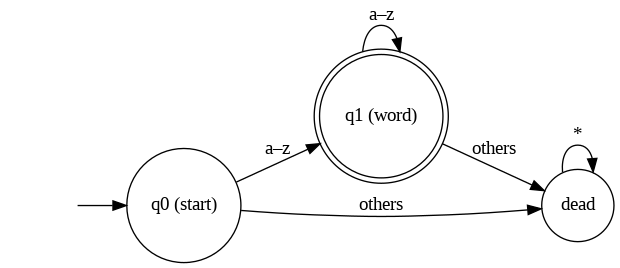

In [2]:
from graphviz import Digraph
# Define DFA details
Q_START = 'q0'
Q_WORD = 'q1'
Q_DEAD = 'q_dead'
accepting = {Q_WORD}

def draw_dfa(filename='dfa_simplified_word'):
    g = Digraph('dfa', format='png')
    g.attr(rankdir='LR')
    # Invisible start node
    g.node('', shape='none')

    # States
    g.node(Q_START, shape='circle', label='q0 (start)')
    g.node(Q_WORD, shape='doublecircle', label='q1 (word)')
    g.node(Q_DEAD, shape='circle', label='dead')

    # Start arrow
    g.edge('', Q_START)

    # Transitions
    g.edge(Q_START, Q_WORD, label='a–z')
    g.edge(Q_START, Q_DEAD, label='others')
    g.edge(Q_WORD, Q_WORD, label='a–z')
    g.edge(Q_WORD, Q_DEAD, label='others')
    g.edge(Q_DEAD, Q_DEAD, label='*')

    # Render and display
    output_path = g.render(filename, cleanup=True)
    from IPython.display import Image
    return Image(filename=output_path)

# Call the function to display DFA in Colab
draw_dfa()


In [ ]:
with open('/brown_nouns.txt', 'r') as f:
    print(f.read())


In [13]:
import sys
import os

def is_vowel(ch):
    return ch in "aeiou"

def read_file(path):
    s = set()
    with open(path, encoding='utf8') as f:
        for line in f:
            w = line.strip()
            if not w:
                continue
            s.add(w.lower())
    return s

def analyze_token(token, nouns_set):

    orig = token
    w = token.lower()

    #quick present check: if exact word is in noun set -> could be SG (but still may be PL too) -> chance hai
    # We'll attempt plural analyses first (try to see if token is plural) then fallback to SG.
    # order: ies -> es -> s -> SG -> Invalid


    #This function checks if a noun can make its plural by just adding “s”
    def valid_regular_s(candidate_root):

        # if root endswith s, z, x, ch, sh -> regular 's' plural is not allowed (should be 'es').
        if candidate_root.endswith(('s','z','x')):
            return False
        if candidate_root.endswith('ch') or candidate_root.endswith('sh'):
            return False


        # if root endswith consonant+y then plural should be 'ies' not 'ys'
        if candidate_root.endswith('y'):
            if len(candidate_root) >= 2:
                if not is_vowel(candidate_root[-2]):  # consonant before y -> uses 'ies'
                    return False
        return True


    # 1) 'ies' => root = w[:-3] + 'y' (only valid if candidate root exists)
    if w.endswith('ies') and len(w) > 3:
        cand = w[:-3] + 'y'
        if cand in nouns_set:
            # additional sanity: only accept if original singular wouldn't be valid with 's' (to avoid wrong matches)
            # e.g., 'cities' -> cand 'city' ok
            return f"{cand}+N+PL"
        # else continue to other checks (maybe it's 'xies' etc. unlikely)

    # 2) 'es' endings
    if w.endswith('es') and len(w) > 2:
        # candidate1: remove 'es' -> maybe root that ends with s,z,x,ch,sh
        cand1 = w[:-2]
        # sometimes words like 'houses' ->  'house' (w[:-1]) so we must check both
        cand2 = w[:-1]  # remove only 's' -> maybe root had final 'e' like 'house' -> 'houses'

        # Accept cand1 if it exists and the root ends with a special ending that typically requires 'es'
        if cand1 in nouns_set and (cand1.endswith(('s','z','x')) or cand1.endswith('ch') or cand1.endswith('sh')):
            return f"{cand1}+N+PL"

        # Accept cand2 if cand2 exists and cand2 does not *require* the 'es' pattern to be 'es' exclusive.
        # Example: 'houses' -> cand1='hous' (no), cand2='house' (yes) => regular plural by adding 's' to house yields 'houses'
        if cand2 in nouns_set and valid_regular_s(cand2):
            return f"{cand2}+N+PL"

        # There are other irregulars; if cand1 in nouns_set we can still accept (defensive)
        if cand1 in nouns_set:
            return f"{cand1}+N+PL"

    # 3) plain 's' endings (not 'es' or 'ies')
    if w.endswith('s') and not w.endswith('es') and not w.endswith('ies') and len(w) > 1:
        cand = w[:-1]
        if cand in nouns_set:
            # but if cand finishes with letter that requires 'es' or 'ies', then cand+"s" is invalid (e.g., foxs)
            if valid_regular_s(cand):
                return f"{cand}+N+PL"
            else:
                return "Invalid Word"

    # 4) fallback: if token exactly in noun set => singular
    if w in nouns_set:
        return f"{w}+N+SG"

    #  invalid
    return "Invalid Word"

def process_file(path):
    nouns_set = read_file(path)
    out_lines = []
    with open(path, encoding='utf8') as f:
        for raw in f:
            tok = raw.strip()
            if not tok:
                continue
            analysis = analyze_token(tok, nouns_set)
            out_lines.append(f"{tok} = {analysis}")
    return out_lines

file_path = "/brown_nouns.txt"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    results = process_file(file_path)
    for line in results ,range(10):
        print(line)

['investigation = investigation+N+SG', 'primary = primary+N+SG', 'election = election+N+SG', 'evidence = evidence+N+SG', 'irregularities = irregularity+N+PL', 'place = place+N+SG', 'jury = jury+N+SG', 'presentments = presentments+N+SG', 'charge = charge+N+SG', 'election = election+N+SG', 'praise = praise+N+SG', 'thanks = thanks+N+SG', 'manner = manner+N+SG', 'election = election+N+SG', 'term = term+N+SG', 'jury = jury+N+SG', 'reports = report+N+PL', 'irregularities = irregularity+N+PL', 'primary = primary+N+SG', 'handful = handful+N+SG', 'reports = report+N+PL', 'jury = jury+N+SG', 'interest = interest+N+SG', 'election = election+N+SG', 'number = number+N+SG', 'voters = voter+N+PL', 'size = size+N+SG', 'city = city+N+SG', 'jury = jury+N+SG', 'registration = registration+N+SG', 'election = election+N+SG', 'laws = law+N+PL', 'legislators = legislator+N+PL', 'laws = law+N+PL', 'end = end+N+SG', 'jury = jury+N+SG', 'number = number+N+SG', 'topics = topic+N+PL', 'departments = department+N+

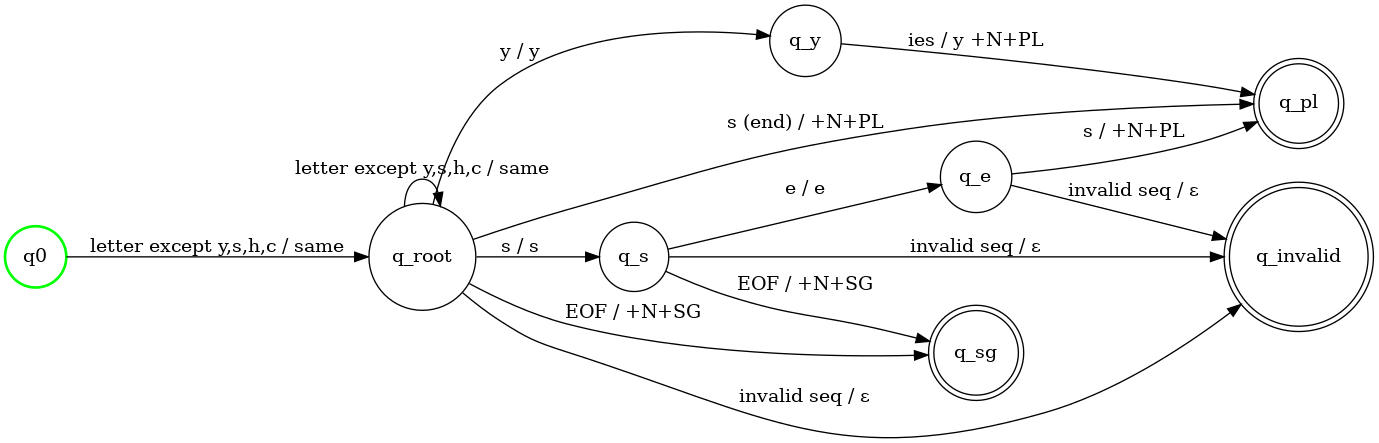

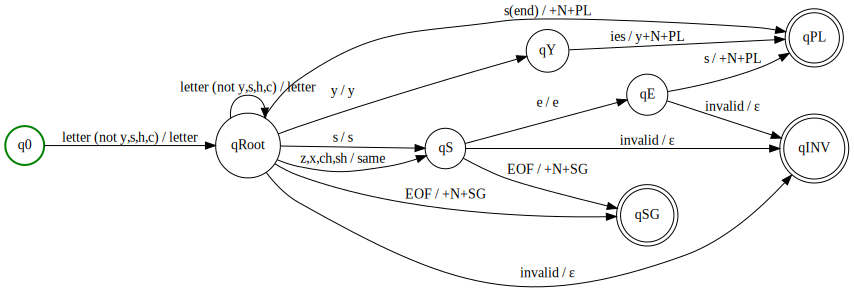

In [11]:
import graphviz

# Initialize directed graph
fst = graphviz.Digraph('NounPluralFST', format='png')
fst.attr(rankdir='LR')

# States: q0 = start, qSG = singular final, qPL = plural final, qINV = invalid final
states = {
    "q0": {"start": True, "final": False},
    "qRoot": {"start": False, "final": False},
    "qY": {"start": False, "final": False},
    "qS": {"start": False, "final": False},
    "qE": {"start": False, "final": False},
    "qSG": {"start": False, "final": True},
    "qPL": {"start": False, "final": True},
    "qINV": {"start": False, "final": True}
}

# Add states
for name, props in states.items():
    if props["start"]:
        fst.node(name, shape="circle", style="bold", color="green")
    elif props["final"]:
        fst.node(name, shape="doublecircle")
    else:
        fst.node(name, shape="circle")

# Transitions
fst.edge("q0", "qRoot", label="letter (not y,s,h,c) / letter")
fst.edge("qRoot", "qRoot", label="letter (not y,s,h,c) / letter")

# Y-ending rule
fst.edge("qRoot", "qY", label="y / y")
fst.edge("qY", "qPL", label="ies / y+N+PL")

# E-insertion rule
fst.edge("qRoot", "qS", label="s / s")
fst.edge("qRoot", "qS", label="z,x,ch,sh / same")
fst.edge("qS", "qE", label="e / e")
fst.edge("qE", "qPL", label="s / +N+PL")

# Simple S-addition
fst.edge("qRoot", "qPL", label="s(end) / +N+PL")

# Singular word ending
fst.edge("qRoot", "qSG", label="EOF / +N+SG")
fst.edge("qS", "qSG", label="EOF / +N+SG")

# Invalid sequences
fst.edge("qRoot", "qINV", label="invalid / ε")
fst.edge("qS", "qINV", label="invalid / ε")
fst.edge("qE", "qINV", label="invalid / ε")


fst
